In [142]:
# LIBRERIAS

import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import TimeSeriesSplit
import math
from sklearn.metrics import mean_squared_error

tf.config.list_physical_devices('GPU') 



[]

In [134]:
# Lectura de ficheros con los datasets de las empresas a analizar

companies = {}
ficheros = os.listdir('data')

for file in ficheros:
    company = file[:-4]
    dfcompany = pd.read_csv(f"data/{file}")
    companies[company] = dfcompany




In [135]:
# Tomamos datos de amazon para pruebas con el modelo.
dfcompany = companies['AMZN']
dfcompany

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AMZN,2017-04-24 00:00:00+00:00,907.41,909.990,903.8200,908.68,3118123,907.41,909.990,903.8200,908.68,3118123,0.0,1.0
1,AMZN,2017-04-25 00:00:00+00:00,907.62,909.480,903.0000,907.04,3367734,907.62,909.480,903.0000,907.04,3367734,0.0,1.0
2,AMZN,2017-04-26 00:00:00+00:00,909.29,915.749,907.5600,910.30,2562595,909.29,915.749,907.5600,910.30,2562595,0.0,1.0
3,AMZN,2017-04-27 00:00:00+00:00,918.38,921.860,912.1100,914.39,4255693,918.38,921.860,912.1100,914.39,4255693,0.0,1.0
4,AMZN,2017-04-28 00:00:00+00:00,924.99,949.590,924.3335,948.83,7278819,924.99,949.590,924.3335,948.83,7278819,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,AMZN,2022-04-14 00:00:00+00:00,3034.13,3117.940,3029.4350,3107.80,2579907,3034.13,3117.940,3029.4350,3107.80,2579907,0.0,1.0
1255,AMZN,2022-04-18 00:00:00+00:00,3055.70,3080.790,3005.0100,3030.47,2325676,3055.70,3080.790,3005.0100,3030.47,2325676,0.0,1.0
1256,AMZN,2022-04-19 00:00:00+00:00,3162.31,3172.980,3031.0100,3040.59,2746321,3162.31,3172.980,3031.0100,3040.59,2746321,0.0,1.0
1257,AMZN,2022-04-20 00:00:00+00:00,3079.96,3152.050,3072.0700,3152.05,2958600,3079.96,3152.050,3072.0700,3152.05,2958600,0.0,1.0


In [136]:
# Crreación de una matriz de datos de para la red neuronal
def create_dataset(dataset, look_back):
	x_data, y_data = [], []
	for i in range(len(dataset)-look_back-1):
		x = dataset[i:(i+look_back), 0]
		x_data.append(x)
		y = dataset[i + look_back, 0]
		y_data.append(y)
        
	return np.array(x_data), np.array(y_data)

def graficar(dfcompany, company):
	plt.plot(dfcompany)
	plt.xlabel('Days')
	plt.ylabel('Price')
	plt.title(label=company)

# Graficar el resultado
def graficarResultado(dfcompany, look_back, train_predict, test_predict):
    # Ajustamos los datos para mostrar la predicción
    trainPredictPlot = np.empty_like(dfcompany)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict
    
    testPredictPlot = np.empty_like(dfcompany)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(look_back*2)+1:len(dfcompany)-1, :] = test_predict

    # Mostrar las los datos originales y la predicción
    plt.plot(scaler.inverse_transform(dfcompany), label='Original data')
    plt.plot(trainPredictPlot, label='Train prediction')
    plt.plot(testPredictPlot, label='Test prediction')
    plt.legend()
    
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.show()
	
#Separar datos de entrenamiento y test
def split(dfcompany, look_back, percent=70):
    training_size = int(len(dfcompany)*percent) 
    test_size = len(dfcompany)-training_size 

    train_data, test_data = dfcompany[0:training_size,:], dfcompany[training_size:len(dfcompany),:1]


    #Creamos la matrix para los datos de entrenamiento y test    
    X_train, y_train = create_dataset(train_data, look_back) #(,) (,)
    X_test, y_test = create_dataset(test_data, look_back) #(,) (,)
    #print(f"La matriz X_train tiene la forma: {X_train.shape}")
    #print(f"La matriz y_train tiene la forma: {y_train.shape}")
    #print(f"La matriz X_test tiene la forma: {X_test.shape}")
    #print(f"La matriz y_test tiene la forma: {y_test.shape}")
    

    # Hay que hacer reshape a las entradas de la red LSTM añadiendo 1 dimension [samples, look_back, features]
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


    return X_train, X_test, y_train, y_test



In [137]:
def entrenar(X_train, X_test, y_train, y_test, look_back, nneuronas=50):
    model=Sequential()
    #Capa 1
    model.add(LSTM(int(nneuronas/2),return_sequences=True, input_shape=(look_back,1)))

    #model.add(LSTM(nneuronas,return_sequences=True))
    
    # Capa 2
    model.add(LSTM(int(nneuronas/2)))
        

    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')

    model.summary()

    model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1) # validation_data=(X_test,y_test),

    return model

In [138]:
def prediccion (model, X_train, X_test, y_train, y_test, look_back):
    # Realizar predicción sobre datos de entranamiento y test
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Transformamos los datos a su escala original
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    return  train_predict, test_predict

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_87 (LSTM)               (None, 100, 5)            140       
_________________________________________________________________
lstm_88 (LSTM)               (None, 5)                 220       
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 6         
Total params: 366
Trainable params: 366
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
17/17 [==============================] - 5s 52ms/step - loss: 0.0364
Epoch 2/10
17/17 [==============================] - 1s 49ms/step - loss: 0.0151: 0s - loss
Epoch 3/10
17/17 [==============================] - 1s 50ms/step - loss: 0.0104
Epoch 4/10
17/17 [==============================] - 1s 50ms/step - loss: 0.0061
Epoch 5/10
17/17 [==============================] - 1s

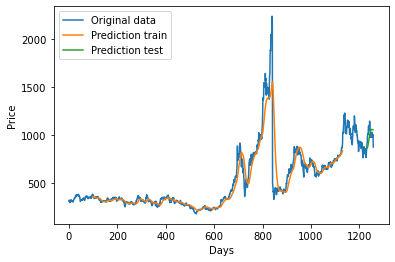

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_89 (LSTM)               (None, 100, 10)           480       
_________________________________________________________________
lstm_90 (LSTM)               (None, 10)                840       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
17/17 [==============================] - 5s 48ms/step - loss: 0.0308
Epoch 2/10
17/17 [==============================] - 1s 49ms/step - loss: 0.0122
Epoch 3/10
17/17 [==============================] - 1s 47ms/step - loss: 0.0073
Epoch 4/10
17/17 [==============================] - 1s 48ms/step - loss: 0.0055: 0s - loss: 0.00
Epoch 5/10
17/17 [==========================

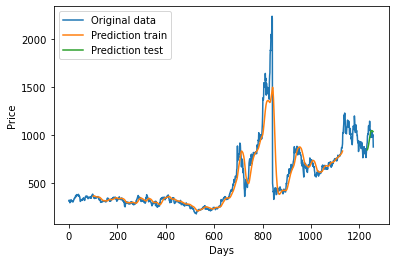

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_91 (LSTM)               (None, 100, 25)           2700      
_________________________________________________________________
lstm_92 (LSTM)               (None, 25)                5100      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 26        
Total params: 7,826
Trainable params: 7,826
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
17/17 [==============================] - 6s 64ms/step - loss: 0.0191
Epoch 2/10
17/17 [==============================] - 1s 71ms/step - loss: 0.0063
Epoch 3/10
17/17 [==============================] - 1s 64ms/step - loss: 0.0046
Epoch 4/10
17/17 [==============================] - 1s 64ms/step - loss: 0.0042
Epoch 5/10
17/17 [==============================] - 1s 64ms/s

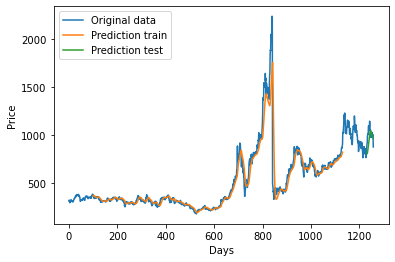

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_93 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
lstm_94 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
17/17 [==============================] - 6s 89ms/step - loss: 0.0162: 0s - los
Epoch 2/10
17/17 [==============================] - 2s 92ms/step - loss: 0.0045: 0s - loss
Epoch 3/10
17/17 [==============================] - 2s 91ms/step - loss: 0.0041
Epoch 4/10
17/17 [==============================] - 2s 91ms/step - loss: 0.0038
Epoch 5/10
17/17 [====================

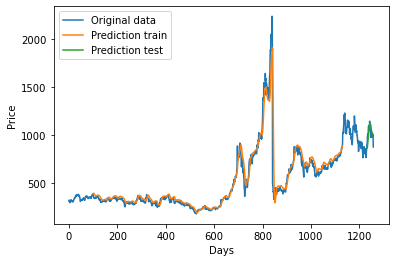

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_95 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
lstm_96 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
17/17 [==============================] - 6s 123ms/step - loss: 0.0142
Epoch 2/10
17/17 [==============================] - 2s 114ms/step - loss: 0.0047
Epoch 3/10
17/17 [==============================] - 2s 115ms/step - loss: 0.0037
Epoch 4/10
17/17 [==============================] - 2s 120ms/step - loss: 0.0038
Epoch 5/10
17/17 [==============================] - 2

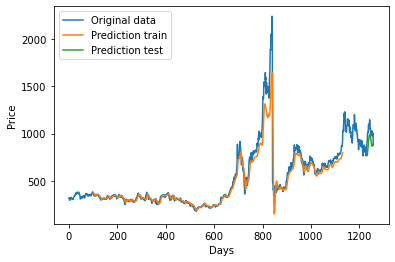

In [139]:
# Definimos cuantos días usará el modelo para predecir el día siguiente
look_back = 100

nneuronas = [10,20,50, 100, 200]



for n in nneuronas:
    dfcompany = companies['TSLA']
    # Por cada empresa, preprocesar, entrenar y guardar resultados
    company = dfcompany.iloc[0,0]

    #graficar(dfcompany, company)

    # Descartamos todas las columnas y nos quedamos unicamente con el precio de cierre de la acción
    dfcompany = dfcompany.reset_index()['close']
    scaler=MinMaxScaler(feature_range=(0,1))
    dfcompany = scaler.fit_transform(np.array(dfcompany).reshape(-1,1))
    X_train, X_test, y_train, y_test = split(dfcompany, look_back, percent=0.9)

    model = entrenar(X_train, X_test, y_train, y_test, look_back, nneuronas=n)

    train_predict, test_predict = prediccion(model, X_train, X_test, y_train, y_test, look_back)

    # Calculamos el error en entrenamiento y test
    train_error = math.sqrt(mean_squared_error(y_train, train_predict))
    test_error = math.sqrt(mean_squared_error(y_test, test_predict))

    print(f"Error entrenamiento: {train_error}")
    print(f"Error test: {test_error}")

    graficarResultado(dfcompany, look_back, train_predict, test_predict)



In [141]:

# Predicción del ultimo dia 
print(scaler.inverse_transform(y_test[24].reshape(-1,1)))
print(test_predict[24])

[[998.02]]
[887.3528]
